### 1. Prepare the working environment

In [ ]:

using Pkg
Pkg.add("IceFloeTracker")
Pkg.add("DataFrames")
Pkg.add("Serialization")

HOME = "../.." # path to the root of the project two levels up

In [ ]:
using IceFloeTracker
using DataFrames
using Serialization: deserialize, serialize
using IceFloeTracker: addfloemasks!, adduuid!, add_passtimes!, addψs!, long_tracker, addlatlon!

### 2. Set thresholds for the algorithm

In [ ]:
# Set thresholds
candidate_filter_settings = IceFloeTracker.candidate_filter_settings
candidate_matching_settings = IceFloeTracker.candidate_matching_settings
@show candidate_filter_settings
@show candidate_matching_settings

condition_thresholds = (large_floe_minimum_area = 1200, search_thresholds = (dt = (30.0, 100.0, 1300.0), dist = (200, 250, 300)), small_floe_settings = (arearatio = 0.18, majaxisratio = 0.1, minaxisratio = 0.15, convexarearatio = 0.2), large_floe_settings = (arearatio = 0.28, majaxisratio = 0.1, minaxisratio = 0.12, convexarearatio = 0.14))
mc_thresholds = (goodness = (small_floe_area = 0.18, large_floe_area = 0.236, corr = 0.68), comp = (mxrot = 10, sz = 16))


(goodness = (small_floe_area = 0.18, large_floe_area = 0.236, corr = 0.68), comp = (mxrot = 10, sz = 16))

### 3. Load data

In [ ]:
begin # Load data
    pth = joinpath(HOME, "test", "test_inputs", "tracker")
    floedata = deserialize(joinpath(pth, "tracker_test_data.dat"))
    # test/test_inputs/tracker/tracker_test_data.dat
    passtimes = deserialize(joinpath(pth, "passtimes.dat"))
    props, imgs = deepcopy.([floedata.props, floedata.imgs])

    # Add required fields to props
    addfloemasks!(props, imgs)
    add_passtimes!(props, passtimes)
    addψs!(props)
    adduuid!(props)
end

# Delete some floes
deleteat!(props[1], 1); # delete the first floe in day 1 so it doesn't have a match in day 2
deleteat!(props[2], 5); # delete the fifth floe in day 2 so it doesn't have a match in day 1

# All floes in days 1 and 2 have a match in day 3
# Expected: 5 trajectories, 3 of length 3 and 2 of length 2
nothing # suppress output -- not particularly informative. See the next block.

### 4. View floe data

In [ ]:
# Day 1
props[1][!, [:uuid, :passtime, :area]]

Row,uuid,passtime,area
,String,DateTime,Int32
1,lZ5mWlwrInvY,2022-09-14T12:44:49,3043
2,SLQEC768ugmu,2022-09-14T12:44:49,1292
3,Gco7fd5lt7Uc,2022-09-14T12:44:49,578
4,F2ZWKtzGDmEK,2022-09-14T12:44:49,484


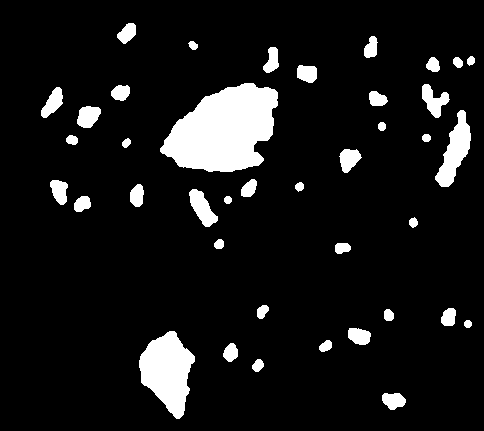

In [ ]:
imshow(arr) = Gray.(arr)
imshow(imgs[1])

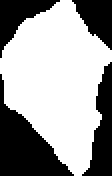

In [ ]:
imshow(props[1][1, :mask])

In [ ]:
# Day 2
props[2][!, [:uuid, :passtime, :area]]

Row,uuid,passtime,area
,String,DateTime,Int32
1,OLBbY2gOqFOW,2022-09-14T13:59:19,6966
2,88TYc8JbIlZB,2022-09-14T13:59:19,2899
3,ID4ZmysV8dQb,2022-09-14T13:59:19,1176
4,K7SdCtCpEXr1,2022-09-14T13:59:19,513


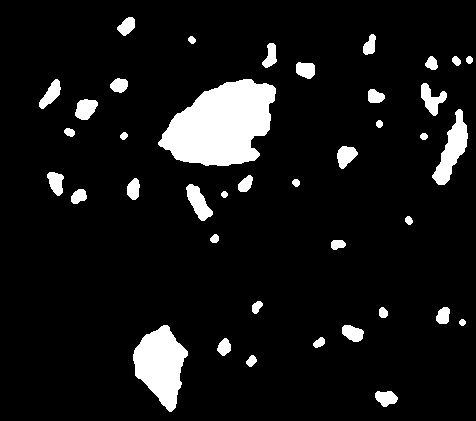

In [ ]:
imshow(imgs[2]) # slightly rotated version of the image in day 1

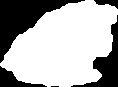

In [ ]:
imshow(props[2][1, :mask])

In [ ]:
# Day 3
props[3][!, [:uuid, :passtime, :area]]

In [ ]:
imshow(props[3][1, :mask]) # missing in day 1

In [ ]:
imshow(props[3][5, :mask]) # missing in day 2

### 5. Pair and label floes

In [ ]:
# Get paired floes with labels
trajectories = long_tracker(props, candidate_filter_settings, candidate_matching_settings);

### 6. View trajectories and _goodness_ of pairings

In [ ]:
trajectories[!, [:ID, :passtime, :area_mismatch, :corr]]

Row,ID,passtime,area_mismatch,corr
,Int64,DateTime,Float64?,Float64?
1,1,2022-09-14T12:44:49,0.0,0.999872
2,1,2022-09-15T12:44:49,missing,missing
3,2,2022-09-14T12:44:49,0.0,0.988498
4,2,2022-09-14T13:59:19,0.0,0.98847
5,2,2022-09-15T12:44:49,missing,missing
6,3,2022-09-14T13:59:19,0.0,0.994582
7,3,2022-09-15T12:44:49,missing,missing
8,4,2022-09-14T12:44:49,0.0,0.991761
9,4,2022-09-14T13:59:19,0.0,0.98739


7. Add latitude/longitude data to trajectories

In [ ]:
latlonimgpth = joinpath(HOME, "test", "test_inputs", "beaufort-chukchi-seas_truecolor.2020162.aqua.250m.tiff")
addlatlon!(trajectories, latlonimgpth)

In [ ]:
# View trajectories with lat/lon data
# Note that the areas are now in physical units (km^2)
cols = [:ID, :area, :passtime, :latitude, :longitude]
trajectories[!, cols]

Row,ID,area,passtime,latitude,longitude
,Int64,Float64,DateTime,Float64,Float64
1,1,31.7219,2022-09-14T12:44:49,65.4586,-172.087
2,1,31.7219,2022-09-15T12:44:49,65.4736,-172.067
3,2,37.8828,2022-09-14T12:44:49,65.1822,-170.872
4,2,33.6226,2022-09-14T13:59:19,65.167,-170.886
5,2,37.8828,2022-09-15T12:44:49,65.1809,-170.877
6,3,456.56,2022-09-14T13:59:19,65.1052,-171.297
7,3,470.848,2022-09-15T12:44:49,65.1228,-171.294
8,4,84.6792,2022-09-14T12:44:49,65.566,-171.934
9,4,77.0764,2022-09-14T13:59:19,65.5578,-171.933


In [ ]:
grouped_trajectories = groupby(trajectories, :ID);

,

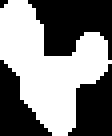
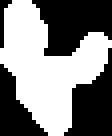

In [ ]:
imshow.(grouped_trajectories[1].mask)

,,

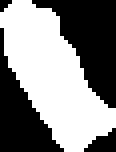
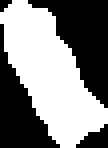
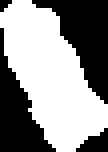

In [ ]:
imshow.(grouped_trajectories[2].mask)

,

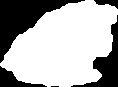
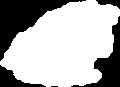

In [ ]:
imshow.(grouped_trajectories[3].mask)

,,

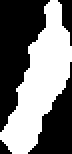
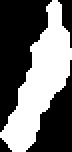
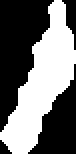

In [ ]:
imshow.(grouped_trajectories[4].mask)

,,

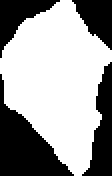
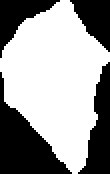
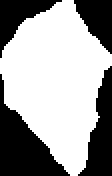

In [ ]:
imshow.(grouped_trajectories[5].mask)